<a href="https://colab.research.google.com/github/ALPHA-CODE-HUB/Tcn-bigru-sequence-classifier/blob/main/tcn_bigru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tcn


In [ ]:
!sed -i 's/self.build_output_shape.as_list()/list(self.build_output_shape)/g' /usr/local/lib/python3.11/dist-packages/tcn/tcn.py

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tcn import TCN
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
data = pd.read_csv('/content/MalBehavD-V1-dataset.csv')
data = data.drop(columns=['sha256'])
y = data['labels']
api_calls = data.drop(columns=['labels']).fillna('')
api_calls = api_calls.apply(lambda x: ' '.join(x.dropna()), axis=1)



In [ ]:
unique_calls = pd.Series(api_calls.str.split().sum()).unique()
label_encoder = LabelEncoder().fit(unique_calls)
api_calls_encoded = api_calls.apply(lambda x: label_encoder.transform(x.split()))


In [ ]:
max_sequence_length = 150
X = pad_sequences(api_calls_encoded, maxlen=max_sequence_length, padding='post')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
unique_api_calls = len(label_encoder.classes_)
embedding_dim = 16

# **TCN-BIGRU**

In [ ]:
model = Sequential(name="TCN-BiGRU_model")
model.add(Embedding(input_dim=unique_api_calls, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(BatchNormalization())

# Use the original TCN layer after patching
model.add(TCN(nb_filters=64, kernel_size=9, dilations=[1, 2, 4, 8], activation='relu', return_sequences=True))

model.add(Bidirectional(GRU(units=256, return_sequences=False, dropout=0.3)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=80,
    batch_size=512,
    callbacks=[early_stopping]
)

Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.6333 - loss: 0.6566 - val_accuracy: 0.5302 - val_loss: 0.6924
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.6590 - loss: 0.6260 - val_accuracy: 0.5406 - val_loss: 0.6911
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.7090 - loss: 0.5955 - val_accuracy: 0.5941 - val_loss: 0.6882
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.7420 - loss: 0.5660 - val_accuracy: 0.5648 - val_loss: 0.6874
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.7730 - loss: 0.5365 - val_accuracy: 0.5941 - val_loss: 0.6854
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.7945 - loss: 0.5022 - val_accuracy: 0.6062 - val_loss: 0.6834
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.8033 - loss: 0.4751 - val_accuracy: 0.6269 - val_loss: 0.6811
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.8183 - loss: 0.4451 - val_accuracy: 0.6028 - val_loss:

# **RESULTS**

In [ ]:
history_dict = history.history

best_train_accuracy = max(history_dict['accuracy'])
best_val_accuracy = max(history_dict['val_accuracy'])

best_train_loss = min(history_dict['loss'])
best_val_loss = min(history_dict['val_loss'])

best_train_accuracy_epoch = history_dict['accuracy'].index(best_train_accuracy) + 1
best_val_accuracy_epoch = history_dict['val_accuracy'].index(best_val_accuracy) + 1

best_train_loss_epoch = history_dict['loss'].index(best_train_loss) + 1
best_val_loss_epoch = history_dict['val_loss'].index(best_val_loss) + 1

print(f"Best Training Accuracy: {best_train_accuracy:.4f} (Epoch {best_train_accuracy_epoch})")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} (Epoch {best_val_accuracy_epoch})")

print(f"Best Training Loss: {best_train_loss:.4f} (Epoch {best_train_loss_epoch})")
print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_val_loss_epoch})")


Best Training Accuracy: 0.9993 (Epoch 76)
Best Validation Accuracy: 0.9465 (Epoch 75)
Best Training Loss: 0.0076 (Epoch 80)
Best Validation Loss: 0.2656 (Epoch 79)


# **Training**

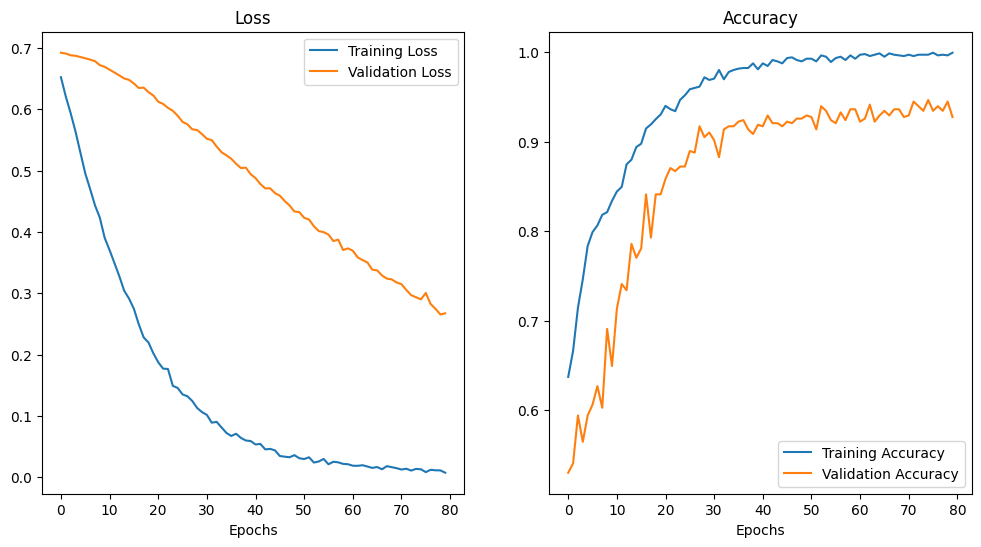

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].plot(history.history["loss"], label="Training Loss")
ax[0].plot(history.history["val_loss"], label="Validation Loss")
ax[0].set_title("Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
ax[1].set_title("Accuracy")
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

# **MODEL EVALUTION**

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("TCN-BiGRU model classification report: \n\n", classification_report(np.array(y_test), y_pred_binary.flatten()))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
TCN-BiGRU model classification report: 

               precision    recall  f1-score   support

           0       0.90      0.95      0.93       326
           1       0.95      0.89      0.92       317

    accuracy                           0.92       643
   macro avg       0.92      0.92      0.92       643
weighted avg       0.92      0.92      0.92       643



# **CONFUSION MATRIX**

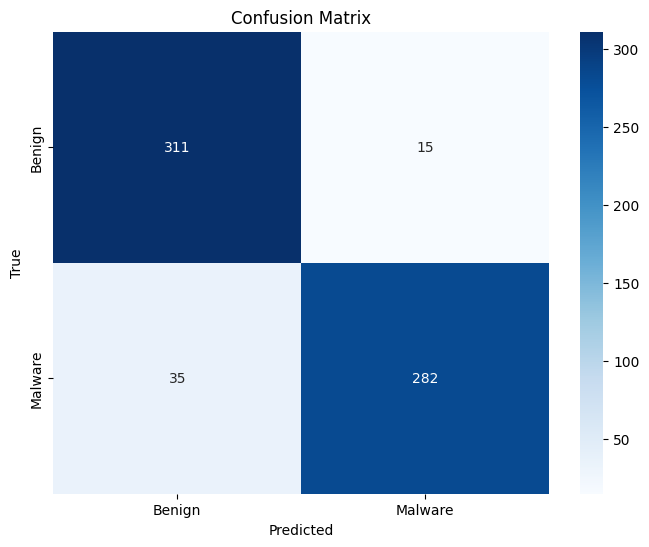

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Receiver operating characteristic (ROC) curve**

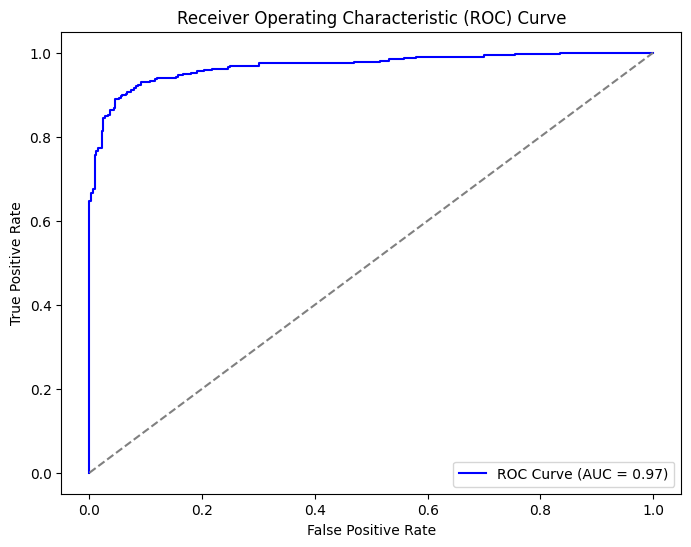

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# **Precision-Recall curve**

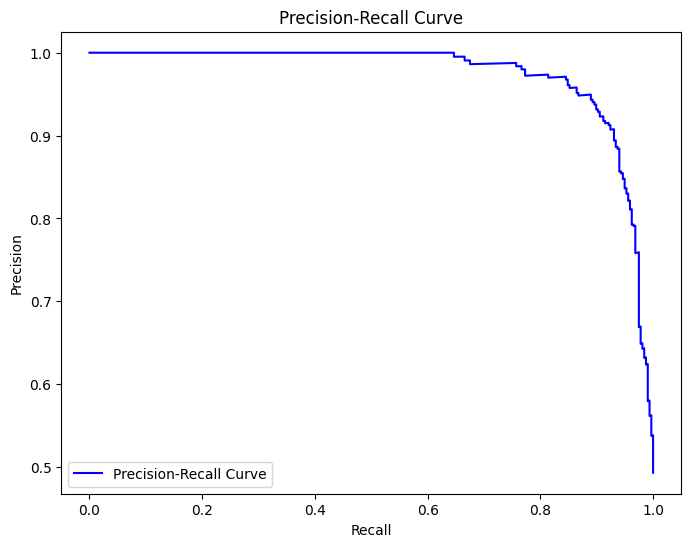

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
